In [45]:
from os import name
import geopandas as gpd
import pandas as pd
import osmnx as ox
import logging
import sqlite3
from pathlib import Path
from shapely.ops import unary_union
from shapely import wkt
import yaml
import logging

import folium
from folium.plugins import MarkerCluster


In [46]:
# Configuración de Logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [47]:
gdf_caba = ox.geocode_to_gdf('Ciudad Autónoma de Buenos Aires, Argentina')


In [48]:
gdf_caba

,geometry,bbox_west,bbox_south,bbox_east,bbox_north,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name
0,"MULTIPOLYGON (((-58.53145 -34.61561, -58.53143...",-58.53145,-34.705815,-58.335142,-34.526553,409586859,relation,3082668,-34.616123,-58.435621,boundary,administrative,8,0.772258,state,Autonomous City of Buenos Aires,"Autonomous City of Buenos Aires, Argentina"


In [49]:
recorte_dissolve = gdf_caba.dissolve()
       
# Buffer de 100m (reproyectando ida y vuelta)
recorte_dissolve = recorte_dissolve.to_crs('EPSG:3857').buffer(100).to_crs('EPSG:4326')

# Unary union y Convex Hull
bordes_recorte = unary_union(recorte_dissolve.geometry).convex_hull

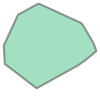

In [50]:
bordes_recorte

In [ ]:
def process_category(polygon, tag: str) -> gpd.GeoDataFrame:
    """
    Procesa una categoría (key) de OSM:
    1. Busca en caché.
    2. Si no está, descarga de OSM.
    3. Calcula centroides.
    4. Guarda en caché.
    """

    # 2. Descargar de OSM
    logger.info(f"Descargando '{tag}' desde OSM API...")
    
    pois = ox.features_from_polygon(polygon=polygon, tags={tag: True})
    pois['osm_tag'] = tag
    df_tags[tag] = pois.reset_index()\
                    .reindex(columns = ['osmid', f'{tag}', 'element_type', 'name', 'osm_tag', 'geometry'])\
                    .rename(columns = {f'{tag}':'tag', 'element_type':'tipo_osm', 'name':'nombre_osm', 'osm_tag':'tag_osm'})
    gdf = pd.concat(df_tags.values(), ignore_index=True)
    gdf = df.to_crs('EPSG:4326')
    gdf['tipo_geometria'] = df.geometry.geom_type
    # Conversión a Centroides (Lógica solicitada)
    # Reproyecta a metros (3857) -> calcula centroide -> vuelve a 4326
    gdf['centroide'] = gdf.geometry.to_crs('EPSG:3857').centroid.to_crs('EPSG:4326')
    gdf = gdf.set_geometry('centroide')
    
    return gdf

In [55]:

osm_tags = [
    "amenity", 
    "leisure",  
    "tourism",
    "shop", 
    "office", 
    "craft", 
    "industrial",
    "clothes"
    ]

all_gdfs = []

for tag in osm_tags:
    gdf = process_category(polygon=bordes_recorte, tag=tag)
    if not gdf.empty:
        all_gdfs.append(gdf)

2025-12-02 18:13:06,669 - INFO - Descargando 'amenity' desde OSM API...
2025-12-02 18:13:08,134 - INFO - Descargando 'leisure' desde OSM API...
2025-12-02 18:13:08,714 - INFO - Descargando 'tourism' desde OSM API...
2025-12-02 18:13:08,916 - INFO - Descargando 'shop' desde OSM API...
2025-12-02 18:13:09,720 - INFO - Descargando 'office' desde OSM API...
2025-12-02 18:13:09,908 - INFO - Descargando 'craft' desde OSM API...
2025-12-02 18:13:10,032 - INFO - Descargando 'industrial' desde OSM API...
2025-12-02 18:13:10,160 - INFO - Descargando 'clothes' desde OSM API...


In [63]:
all_gdfs[0].columns

Index(['osmid', 'tag', 'tipo_osm', 'nombre_osm', 'tag_osm', 'geometry',
       'tipo_geometria', 'centroide'],
      dtype='object')

In [64]:
all_gdfs[0].head()

,osmid,tag,tipo_osm,nombre_osm,tag_osm,geometry,tipo_geometria,centroide
0,NaN,bench,NaN,NaN,amenity,POINT (-58.42509 -34.58936),Point,POINT (-58.42509 -34.58936)
1,NaN,bench,NaN,NaN,amenity,POINT (-58.43801 -34.60499),Point,POINT (-58.43801 -34.60499)
2,NaN,restaurant,NaN,Restaurant Museo Evita,amenity,POINT (-58.41494 -34.58058),Point,POINT (-58.41494 -34.58058)
3,NaN,fuel,NaN,YPF,amenity,POINT (-58.49934 -34.55083),Point,POINT (-58.49934 -34.55083)
4,NaN,fuel,NaN,YPF,amenity,POINT (-58.40047 -34.62228),Point,POINT (-58.40047 -34.62228)
